In [1]:
from IPython.display import Code

# Example: Analysis of RISC-V Instruction Traces with MLonMCU

When experimenting with different RISC-V instruction set extension, it might be helpful to find out which types of instrcutions are really used.

## Supported components

**Models:** Any (`sine_model` used below)

**Frontends:** Any (`tflite` used below)

**Frameworks/Backends:** Any (`tflmi` used below)

**Platforms/Targets:** `etiss`, `spike`, `ovpsim` (`etiss` used below)

## Prerequisites

If not done already, setup a virtual python environment and install the required packages into it. (See `requirements.txt`)

In [2]:
Code(filename="requirements.txt")

-r ../../requirements.txt

Set up MLonmCU as usual, i.e. initialize an environment and install all required dependencies. Feel free to use the following minimal `environment.yml.j2` template:

In [3]:
Code(filename="environment.yml.j2")

---
# The MLONMCU_HOME is filled in automatically when creating the environment
home: "{{ home_dir }}"
logging:
  level: INFO
  to_file: false
  rotate: false
cleanup:
  auto: true
  keep: 5
# Default locations for certain directoriescan be changed here
# Non-absolute paths will always be threated relative to the MLONMCU_HOME
paths:
  # Where the dependencies are downloaded and installed
  deps: deps
  # If logging to file is used keep logs in this directory
  logs: logs
  # Location where reports and artifacts are written to
  results: results
  # Directory where custom extensions can be integrated
  plugins: plugins
  # Directory for intermediate build products, should be located on a large enough drive
  temp: temp
  # A collection of models which will be used to look for models
  # The paths will be checked in the order defined here stopping at the first match
  # Non-existant paths will be skipped without throwing an error
  models:
    - "{{ home_dir }}/models"
# Here default clone_urls
repos:
  tensorflow:
    url: "https://github.com/tensorflow/tflite-micro.git"
    ref: 93d4b1ccc6e0d1a9062acb1d79f21505daf9d940
  etiss:
    url: "https://github.com/tum-ei-eda/etiss.git"
    ref: 40c0b920cf4072adf189211ca44291534355dcfd
  mlif:
    url: "https://github.com/tum-ei-eda/mlonmcu-sw.git"
    ref: c7b0e7364c232666ebd5a17476181e3ff9a71d70
frameworks:
  default: tflm
  tflm:
    enabled: true
    backends:
      default: tflmi
      tflmi:
        enabled: true
        features: {}
    features: {}
frontends:
  tflite:
    enabled: true
    features: []
toolchains:
  gcc: true
platforms:
  mlif:
    enabled: true
    features:
      debug: true
targets:
  default: host_x86
  etiss:
    enabled: true
    features:
      log_instrs: true
  host_x86:
    enabled: true
    features: []
postprocesses:
  use: []
vars:
  allow_extensions: false
  runs_per_stage: true
  riscv_gcc.dl_url: "https://syncandshare.lrz.de/dl/fiD9HnHYkb2V8kNbVQYv242m/rv32gc.tar.gz"
flags: {}

Do not forget to set your `MLONMCU_HOME` environment variable first if not using the default location!

## Usage

The following examples demonstrates the powerful combination Postprocesses and Features provided by MLonMCU for the described use-case.

### A) Command Line Interface

Add the following arguments to your command:

`--feature log_instrs --config log_instrs.to_file=1 --postprocess analyse_instructions`

**Example:**

In [4]:
!mlonmcu flow run sine_model --backend tflmi --target etiss --config etiss.end_to_end_cycles=1 \
        --feature log_instrs --config log_instrs.to_file=1 --postprocess analyse_instructions

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO -  Processing stage LOAD
INFO -  Processing stage BUILD
INFO -  Processing stage COMPILE
INFO -  Processing stage RUN
INFO -  Processing stage POSTPROCESS
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - Done processing runs
INFO - Report:
   Session  Run       Model Frontend Framework Backend Platform Target  Total ROM  Total RAM  ROM read-only  ROM code  ROM misc  RAM data  RAM zero-init data  Validation      Features                                             Config           Postprocesses Comment
0        0    0  sine_model   tflite      tflm   tflmi     mlif  etiss      74834       5072           7500     67322        12      2476                2596        True  [log_instrs]  {'sine_model.output_shapes': {'Identity': [1, ...  [analyse_instructions]       -


The interesting data is exported as an artifact and not shown in the report above. Therefore let's look at the generated files instead.

In [5]:
!mlonmcu export /tmp/exported/ -f --run
!ls /tmp/exported/

INFO - Loading environment cache from file
INFO - Successfully initialized cache
Creating directory: /tmp/exported
Done
analyse_instructions_majors.csv  etiss_out.log		  model.cc.h
analyse_instructions_seq1.csv	 generic_mlonmcu	  report.csv
analyse_instructions_seq2.csv	 generic_mlonmcu.dump	  run.txt
analyse_instructions_seq3.csv	 generic_mlonmcu.srcdump  run_metrics.csv
build_metrics.csv		 load_metrics.csv	  sine_model.tflite
compile_metrics.csv		 mlif			  tflmi_arena_size.txt
custom.ini			 mlif_out.log
etiss_instrs.log		 model.cc


CSV File of the used instruction classes (RISC-V only):

In [6]:
!cat /tmp/exported/analyse_instructions_majors.csv | column -t -s,

Major                Count  Probablity
STORE (Compressed)   683    0.572
OP-IMM (Compressed)  208    0.174
BRANCH               186    0.156
OP-IMM               29     0.024
JALR (Compressed)    21     0.018
STORE                13     0.011
BRANCH (Compressed)  11     0.009
AUIPC                7      0.006
OP                   6      0.005
JAL                  5      0.004


Frequently used instructions:

In [7]:
!cat /tmp/exported/analyse_instructions_seq1.csv | column -t -s,

Sequence  Count  Probablity
csw       666    0.558
caddi     190    0.159
bltu      162    0.136
addi      20     0.017
bne       18     0.015
cswsp     17     0.014
cli       12     0.010
sb        12     0.010
auipc     7      0.006
cbeqz     7      0.006


### B) Python Scripting

Python Imports

In [8]:
from tempfile import TemporaryDirectory
from pathlib import Path
import pandas as pd

from mlonmcu.context.context import MlonMcuContext
from mlonmcu.session.run import RunStage

Benchmark Configuration

In [9]:
FRONTEND = "tflite"
MODEL = "sine_model"
BACKEND = "tflmi"
PLATFORM = "mlif"
TARGET = "etiss"
FEATURES = ["log_instrs"]
CONFIG = {"log_instrs.to_file": True}
POSTPROCESSES = ["analyse_instructions"]

Initialize and run a single benchmark

In [10]:
with MlonMcuContext() as context:
    with context.create_session() as session:
        run = session.create_run(config=CONFIG)
        run.add_features_by_name(FEATURES, context=context)
        run.add_frontend_by_name(FRONTEND, context=context)
        run.add_model_by_name(MODEL, context=context)
        run.add_backend_by_name(BACKEND, context=context)
        run.add_platform_by_name(PLATFORM, context=context)
        run.add_target_by_name(TARGET, context=context)
        run.add_postprocesses_by_name(POSTPROCESSES)
        session.process_runs(context=context)
        report = session.get_reports()
report.df

INFO - Loading environment cache from file
INFO - Successfully initialized cache
INFO - [session-1] Processing all stages
INFO - All runs completed successfuly!
INFO - Postprocessing session report
INFO - [session-1] Done processing runs


,Session,Run,Model,Frontend,Framework,Backend,Platform,Target,Total ROM,Total RAM,ROM read-only,ROM code,ROM misc,RAM data,RAM zero-init data,Validation,Features,Config,Postprocesses,Comment
0,1,0,sine_model,tflite,tflm,tflmi,mlif,etiss,74834,5072,7500,67322,12,2476,2596,True,[log_instrs],"{'sine_model.output_shapes': {'Identity': [1, ...",[analyse_instructions],-


The report is available as pandas dataframe.

Let's extract the artifacts created by the `analyse_instructions` postprocess:

In [11]:
artifacts = session.runs[0].artifacts_per_stage[RunStage.POSTPROCESS]["default"]

**Visualization of used Instruction types**

[2023-12-30 00:44:10]::INFO - Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face (unknown file format; error code 0x2)
[2023-12-30 00:44:11]::INFO - generated new fontManager


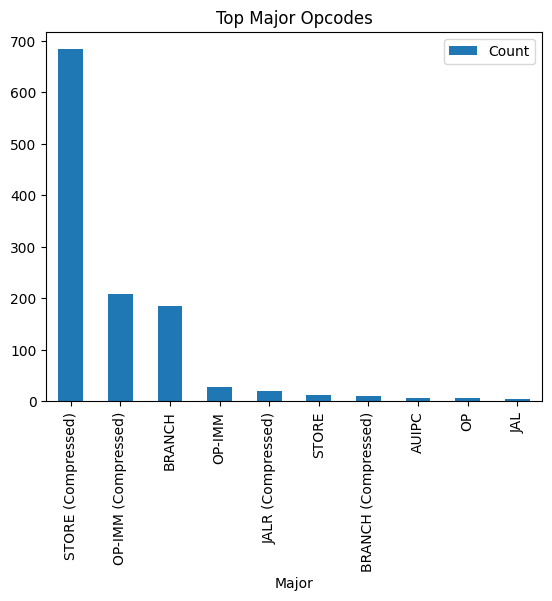

In [12]:
with TemporaryDirectory() as tmpdirname:
    dest = Path(tmpdirname) / "analyse_instructions_majors.csv"
    artifacts[0].export(dest)
    majors_df = pd.read_csv(dest)
    majors_df = majors_df.drop("Probablity", axis=1)
    majors_df.plot.bar(x="Major", title=f"Top Major Opcodes")

**Most used (groups of) intructions in the program**

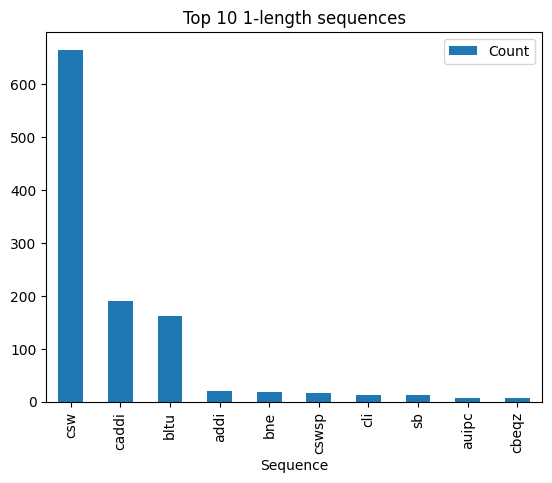

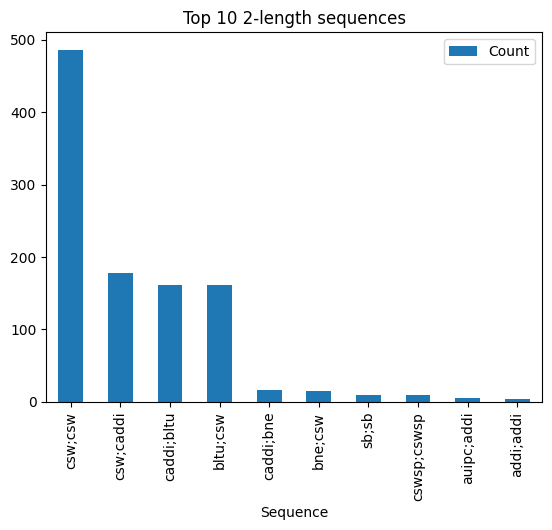

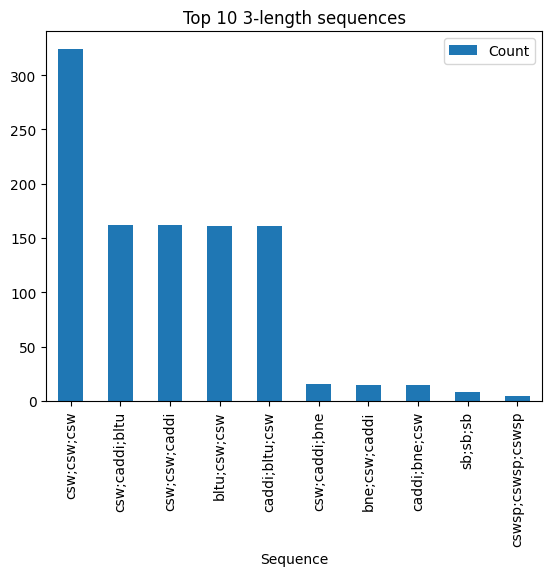

In [13]:
with TemporaryDirectory() as tmpdirname:
    for i in range(1, 4):
        dest = Path(tmpdirname) / f"analyse_instructions_seq{i}.csv"
        artifacts[i].export(dest)
        seq_df = pd.read_csv(dest)
        top = len(seq_df)
        seq_df = seq_df.drop("Probablity", axis=1)
        seq_df.plot.bar(x="Sequence", title=f"Top {top} {i}-length sequences")